<a href="https://colab.research.google.com/github/sangyh/LANL_earthquake_prediction/blob/master/Earthquake_Prediction_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Dependencies

In [3]:
!pip install kaggle
!pip install catboost
!pip install numpy==1.15.0


Import libraries 

In [0]:
import pandas as pd
import numpy as np

from catboost import CatBoostRegressor, Pool

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.svm import NuSVR, SVR

from sklearn.kernel_ridge import KernelRidge

#data viz
import matplotlib.pyplot as plt

In [30]:
#import data into colab file
from google.colab import files

uploaded=files.upload()

In [0]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 /root/.kaggle/kaggle.json

In [7]:
#list competitions
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2565           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      10313            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4068           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         36           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2582           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2927           False  
aerial-c

In [22]:
#download earthquake data
!kaggle competitions download -c LANL-Earthquake-Prediction --force

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 25.9MB/s]
 99% 240M/242M [00:02<00:00, 137MB/s]
100% 242M/242M [00:02<00:00, 119MB/s]
100% 2.03G/2.03G [00:37<00:00, 36.8MB/s]
100% 2.03G/2.03G [00:37<00:00, 57.6MB/s]


In [1]:
#unzip training date
!ls

!unzip train.csv


sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip
Archive:  train.csv
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


Exploratory Data Analysis

In [5]:
train=pd.read_csv('train.csv',nrows=10000000,dtype={'acoustic_data':np.int16,'time_to_failure':np.float64})
train.tail()

,acoustic_data,time_to_failure
9999995,4,10.412898
9999996,6,10.412898
9999997,6,10.412898
9999998,4,10.412898
9999999,1,10.412898


In [6]:
train.describe()

,acoustic_data,time_to_failure
count,1.000000e+07,1.000000e+07
mean,4.502072e+00,5.183598e+00
std,1.780707e+01,5.091286e+00
min,-4.621000e+03,7.954798e-04
25%,2.000000e+00,6.498971e-01
50%,4.000000e+00,1.298899e+00
75%,7.000000e+00,1.089170e+01
max,3.252000e+03,1.154080e+01


In [0]:
#visualize 1% of the data using step of 100
acoustic_sample=train['acoustic_data'].values[::100]
time2failure_sample=train['time_to_failure'].values[::100]

In [17]:
len(acoustic_sample)

100000

In [0]:
def plot(data1,data2):
  fig,ax1=plt.subplots(figsize=(12,8))
  plt.title('Sample earthquake data',color='b')
  plt.plot(data1)
  ax1.set_ylabel('acoustic data')
  plt.legend(['acoustic data'],loc=(0.8,0.95))
  
  ax2=ax1.twinx()
  plt.plot(data2,color='r')
  ax2.set_ylabel('time to failure')
  plt.legend(['time to failure'],loc=(0.8,0.9))
  plt.show()

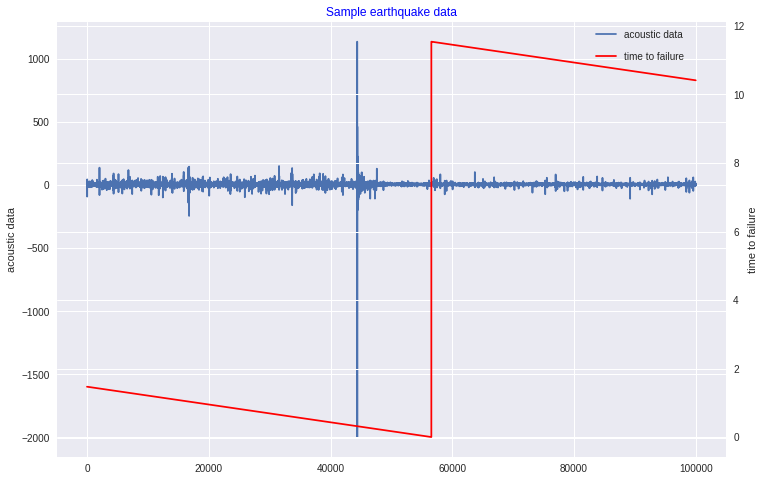

In [19]:
plot(acoustic_sample,time2failure_sample)

In [11]:
#visualize 10% of the data using step of 100
acoustic_sample=train['acoustic_data'].values[::10]
time2failure_sample=train['time_to_failure'].values[::10]
plot(acoustic_sample,time2failure_sample)

TypeError: ignored

**Feature Engineering**

In [0]:
#lets delete vairbales not needed
del train
del acoustic_sample
del time2failure_sample

In [0]:
#function to generate statistical features for segments
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [0]:
#now let's read entire training set in chunks

train=pd.read_csv('train.csv',iterator=True,chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train=pd.DataFrame()
y_train=pd.Series()

for df in train:
  ch=gen_features(df['acoustic_data'])
  X_train=X_train.append(ch,ignore_index=True)
  y_train=y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [9]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000
mean,4.559609,6.479808,-146.831504,160.938255,67.524302,0.125888,-11.067283,-2.108164,11.232725,20.253367,167.568057,5.564552,5.689902
std,0.232548,8.485830,262.122210,265.723939,69.689400,0.477554,14.409522,2.342671,2.352923,14.591981,292.940199,1.522387,8.317705
min,3.798020,2.802720,-5515.000000,23.000000,0.648602,-4.091826,-336.000000,-39.000000,9.000000,11.000000,23.000000,4.256987,2.620528
25%,4.394120,4.461118,-152.000000,91.000000,27.705736,-0.038390,-13.000000,-3.000000,10.000000,15.000000,93.000000,5.079770,3.848382
50%,4.554230,5.544401,-109.000000,121.000000,45.164292,0.087368,-10.000000,-2.000000,11.000000,19.000000,125.000000,5.388163,4.732088
75%,4.716075,6.803792,-79.000000,168.000000,77.787776,0.251311,-6.000000,-1.000000,12.000000,22.250000,173.000000,5.760430,5.820324
max,5.391993,153.703569,-15.000000,5444.000000,631.158927,4.219429,-2.000000,0.000000,50.000000,337.000000,5515.000000,32.762073,150.432368


**Implement CatBoost**

In [10]:
train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 1.758138706286547}}

**Implement SVM with RBF**

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR

In [0]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)